<a target="_blank" href="https://colab.research.google.com/drive/1dHDHhM1BDRJopsj88Rq_QQ38d0sK7XcI?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# RAG with Fireworks and MongoDB Triggers

When you are working with a realtime application, you want to be able to embed your dataset in real time as they are inserted. Fireworks can help with that when used together with MongoDB triggers.

## Trigger Setup
### Adding Fireworks Key to Values
API keys are an important part of the overall setup, and we want to store the secrets properly. We want to obtain a Fireworks API key and then store them as Values in MongoDB Atlas

First, login to [Fireworks](https://fireworks.ai/) , register and then get a free API key to start with

![New Project.png](./assets/New%20Project.png)

You want to store this API key into Atlas as a secret. Note that you cannot directly access the secret in triggers. So we will create a secret with the name fireworksApiKey
![image-2.png](./assets/create_secret.png)

And then create a value that is linked to the secret, and we will call this value FIREWORKS_API_KEY
![image.png](./assets/create_value.png)

## Creating the trigger to fetch embeddings
Now we will create the trigger for fetching the embeddings. In order to do that, we will make use of the sample restaurant dataset from Atlas. More details on how to load the dataset please check out [this guide](https://www.mongodb.com/docs/atlas/sample-data/#std-label-available-sample-datasets). For now we will assume the Sample Restaurants Dataset is loaded, and each of the restaurant object looks like this
```json
{
  "_id": {
    "$oid": "5eb3d668b31de5d588f4292a"
  },
  "address": {}, 
  "borough": "Brooklyn",
  "cuisine": "American",
  "grades": [],
  "name": "Riviera Caterer",
  "restaurant_id": "40356018"
}
```

We will create a new trigger named `Restaurant-Trigger`. We will point that trigger to the MongoDB database `sample_restaurants` and collection `restaurants`. Make sure `Full Document` is supported, since we need the whole document to be able to generate a good embedding for it.

![image.png](./assets/create_trigger.png)

## The trigger code

In order to build the trigger code, we need the basic function to 
- query the embedding on fireworks
- store the embedding on the object

```typescript
exports = async function(changeEvent) {
  const url = 'https://api.fireworks.ai/inference/v1/embeddings';

  // Fetch the FIREWORKS key stored in the context values.
  const fireworks_api_key = context.values.get("FIREWORKS_API_KEY");

  // Access the _id of the changed document:
  const docId = changeEvent.documentKey._id;
  const doc = changeEvent.fullDocument;
  
  // Skip processing if the document already has an embedding
  if ('embedding' in doc) {
    console.log("Document already has an embedding, skipping processing.");
    return;
  }



  // Prepare the request string for the Fireworks' nomic-ai model.
  // For generating document embedding, make sure we prefix with search_document.
  // for more information on how to query nomic-ai model, please check
  // https://huggingface.co/nomic-ai/nomic-embed-text-v1.5
  // TODO: if key embedding is in doc, ignore the doc
  const reqString = `search_document: ` + JSON.stringify(doc)
  console.log(`reqString: ${reqString}`);

  // Call Fireworks API to get the response.

  let resp = await context.http.post({
      url: url,
      headers: {
          'Authorization': [`Bearer ${fireworks_api_key}`],
          'Content-Type': ['application/json']
      },
      body: JSON.stringify({
          model: "nomic-ai/nomic-embed-text-v1.5",
          input: reqString,
      })
  });

  // Parse the JSON response
  let responseData = JSON.parse(resp.body.text());

  // Check the response status.
  if(resp.statusCode === 200) {
    console.log("Successfully received code.");
    console.log(JSON.stringify(responseData));
    console.log(docId);
    const collection = context.services.get("test-rag-cluster").db("sample_restaurants").collection("restaurants");
    await collection.updateOne({ _id: docId }, { $set: { embedding: responseData.data[0].embedding } });
    return true;

  } else {
    console.log("Show status code.");
    console.log(resp.statusCode);
    return false;
  }
}

Create a new function with the definition above, hit save.
Now I can trigger some random update on the doc, and wait for the trigger to execute. We can see that the emebdding field is now filled **automatically**!

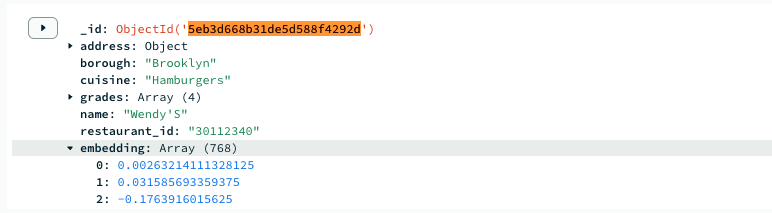

### reload the dataset and setup the index

Now let's try to refresh the dataset and then query the dataset

In [1]:
!pip install -q pymongo fireworks-ai tqdm openai


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pymongo

mongo_url = input()
client = pymongo.MongoClient(mongo_url)

Now we are going to trigger some updates to get the embeddings generated

In [3]:
# Specify the database and collection
db = client.sample_restaurants
collection = db.restaurants

# Iterate over the first 100 documents
for doc in collection.find().limit(100):
    # Perform a minor update (e.g., adding a temporary field and then removing it)
    collection.update_one({'_id': doc['_id']}, {'$set': {'temp_field': 1}})
    collection.update_one({'_id': doc['_id']}, {'$unset': {'temp_field': ""}})

print("Completed updates.")


Completed updates.


You should be able to see that in our logs there are many, many triggers being called, and all the objects that has been touched, now has an embedding associated with it.

### Querying the embedded documents
Now let's make use of the examples we had in the previous cookbooks to find the best burger joint in Brooklyn. Make sure the vector index is setup as follows. We will name it `restaurant_index`

```json
{
  "fields": [
    {
      "type": "vector",
      "path": "embedding",
      "numDimensions": 768,
      "similarity": "dotProduct"
    }
  ]
}
```

In [9]:
from typing import List
embedding_model_string = "nomic-ai/nomic-embed-text-v1.5"
vector_database_field_name = "embedding"

def generate_embeddings(input_texts: str, model_api_string: str, prefix="") -> List[float]:
    """Generate embeddings from Fireworks python library

    Args:
        input_texts: a list of string input texts.
        model_api_string: str. An API string for a specific embedding model of your choice.
        prefix: what prefix to attach to the generate the embeddings, which is required for nomic 1.5. Please check out https://huggingface.co/nomic-ai/nomic-embed-text-v1.5#usage for more information

    Returns:
        reduced_embeddings_list: a list of reduced-size embeddings. Each element corresponds to each input text.
    """
    if prefix:
        input_texts = [prefix + text for text in input_texts] 
    return fw_client.embeddings.create(
        input=input_texts,
        model=model_api_string,
    ).data[0].embedding

import openai
fw_client = openai.OpenAI(
  api_key=input(),
  base_url="https://api.fireworks.ai/inference/v1"
)

# Example query.
query = "What is the best burger joint in Brooklyn?"
prefix="search_query: "
query_emb = generate_embeddings([query], embedding_model_string, prefix=prefix)

results = collection.aggregate([
  {
    "$vectorSearch": {
      "queryVector": query_emb,
      "path": vector_database_field_name,
      "numCandidates": 100, # this should be 10-20x the limit
      "limit": 10, # the number of documents to return in the results
      "index": 'restaurant_index', # the index name you used in the earlier step
    }
  }
])
results_as_dict = {doc['name']: doc for doc in results}

print(f"From your query \"{query}\", the following restaurants were found:\n")
print("\n".join([str(i+1) + ". " + name for (i, name) in enumerate(results_as_dict.keys())]))

From your query "What is the best burger joint in Brooklyn?", the following restaurants were found:

1. White Castle
2. Sonny'S Heros
3. Wendy'S
4. Shashemene Int'L Restaura
5. Taste The Tropics Ice Cream
6. Mejlander & Mulgannon
7. Shell Lanes
8. Wilken'S Fine Food
9. Carvel Ice Cream
10. Seuda Foods


Looks like the model decided that White Castle is the best burger joint in Brooklyn, which I cannot argue with.

## What's Next
- Triggers can actually be very sophisticated and can be used for further processing. If you are interested, please check out the MongoDB blog [here](https://www.mongodb.com/developer/products/mongodb/atlas-open-ai-review-summary/)